In [ ]:
run_program()

# Main

In [57]:
def run_program():
    # Enter a Artist and Song
    input_user = user_input()

    # Is this song in the Billboard top 100
    inBillboard = hot_or_not(input_user[0], input_user[1])

    # If not recommend a similar song
    if inBillboard == False:
        recommendation(input_user[0], input_user[1])

# Functions

In [32]:
def user_input():
    '''
    takes the input of a user, checks regex string and returns tuple: artist_name, song
    '''
    import re
    import time
    import sys
    
    artist_input = input('Artist: ')
    
    while not re.match(".{4,10}", artist_input):
            print ("Please enter a valid artist")
            artist_input = input('Artist: ')

    song_input = input('Song: ')
    while not re.match(".{4,15}", song_input):
            print ("Please enter a valid song")
            song_input = input('Song: ')
    return artist_input, song_input

In [33]:
def hot_or_not (artist_name, song):
    '''
    determines if artist is in Billboard top 100 database
    '''
    
    import time

    contains_artist = billboard_top['artist'].str.contains(artist_name)
    contains_title = billboard_top['song'].str.contains(song)
    results = pd.DataFrame({'contains_artist': contains_artist, 'contains_title': contains_title, "match": contains_artist & contains_title})

    if results['match'].any():
        s = True
        print ("Artist + Track is on the Billboard top 100")
    else:
        s = False
        print ("Artist + Track is NOT on the Billboard top 100, but we have something else for you...")
        time.sleep(2)
        print('... recommendation process starts ...')
        time.sleep(2)
        print('...')
        time.sleep(2)
        print('...')
        time.sleep(2)
    return s

In [34]:
def recommendation(artist_name, song):
    '''
    retrieves track information from spotify and returns a matching song from our pre crawled database
    '''
    import time
    
    # find track id based on user input
    try: track_id = sp.search(q="artist:" + artist_name + " track:" + song, type="track")['tracks']['items'][0]['id']
    
    except IndexError:
        print('We could not find any results, please check for typos and try again:')
        run_programm()
        return
        
    #extract audio features for track id
    audio_features = sp.audio_features(track_id)
    
    # append audio_features to a dataframe
    X_song = pd.DataFrame()
    X_song = X_song.append(audio_features)
    
    # drop columns
    X_song.drop(['id', 'track_href', 'type', 'uri', 'analysis_url'], axis = 1)
    
    # sort columns to initial dataframe
    X_song = X_song[X_prep_df.columns]
    
    # normalize user input result
    X_song_prep = scaler.transform(X_song)
    
    # Predict
    kmeans.predict(X_song_prep)
    
    #filter database for cluster
    song_recommendation = df[df['clusters']==int(kmeans.predict(X_song_prep))]
    
    #random extract from database
    recommendation_lst = song_recommendation.sample(n = 1).values.tolist()
    
    #Print results
    print('Song Name ' + str(recommendation_lst[0]).split(',')[13])
    print('Artist 1 ' + str(recommendation_lst[0]).split(',')[14])
    print('Artist 2 ' +str(recommendation_lst[0]).split(',')[15])
    time.sleep(2)
    print('...')
    print('enjoy!')

In [35]:
def elbow_inertia(r):
    '''
    plots the elbow graph for a given number of clusters for k-mean algorithm
    '''
    K = range(1,r)
    inertias = []

    for k in K:
        kmeans = KMeans(n_clusters = k, random_state=1234)
        kmeans.fit(X_prep_df)
        inertias.append(kmeans.inertia_)
    
    import matplotlib.pyplot as plt
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('# Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

# Data preparation

## Billboard Top 100

In [36]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

url = 'https://www.billboard.com/charts/hot-100'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

In [37]:
#song_names
song_lst = []
song_names = soup.select('span.chart-element__information__song')

for song in song_names:
    song_lst.append(song.text)

In [38]:
#artist_names
artist_lst = []
artist_names = soup.select('span.chart-element__information__artist')

for artist in artist_names:
    artist_lst.append(artist.text)

In [39]:
#ranking
ranking_lst = []
ranking_names = soup.select('span.chart-element__rank__number')

for rank in ranking_names:
    ranking_lst.append(rank.text)

In [40]:
billboard_top = pd.DataFrame({'rank':ranking_lst, 'artist': artist_lst, 'song': song_lst})

In [41]:
billboard_top.to_csv('billboard_top.csv')

## Spotify Data extraction

In [42]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import getpass
import pandas as pd
from tqdm.notebook import tqdm

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="7ac25cd2df894d4587f18918f0776908",
                                                           client_secret="947331b0345946ef847d79f23802ee84"))

In [ ]:
################################################################################################# 
# do not run, will extract all the information from spotify instead load .csv file "spotifydf.csv" 
# from repo as speciefied below
#################################################################################################
spotifydf = pd.DataFrame()
artistdf = pd.DataFrame()
track_lst = []
artist_1 = []
artist_2 = []

#looping through categories
try:
    for category in tqdm(sp.categories(limit=15)['categories']['items']):

        #looping through playlists, ignoring ids that do not exist
        try:
            for playlist in sp.category_playlists(category_id=category['id'], country=None, limit=15, offset=0)['playlists']['items']:

                #looping through tracks, ignoring ids that do not exist
                try:
                    for tracks in sp.playlist_tracks(playlist['id'])['items']:
                        ids = tracks['track']['id']

                        #adding rows of audio_features
                        spotifydf = spotifydf.append(sp.audio_features(tracks['track']['id']))

                        #lst of track names
                        track_lst.append(sp.track(ids)['name'])

                        #lst of artist 1
                        artist_1.append(sp.track(ids)['artists'][0]['name'])

                        #lst of artist 2
                        try: artist_2.append(sp.track(ids)['artists'][1]['name'])
                        except: artist_2.append('')
                except:
                    print('Track-ID not found error')
                    pass
        except:
            print('Playlist-ID not found error')
            pass
                    
except requests.exceptions.ReadTimeout:
    print("ReadTimeout")

finally: 
    spotifydf['track_names'] = track_lst
    spotifydf['artist_1'] = artist_1
    spotifydf['artist_2'] = artist_2
    
    #save data to backupfile
    spotifydf.to_csv('spotifydf.csv', index_col = 0)

In [43]:
#reading from backup
df = pd.read_csv('spotifydf.csv', index_col = 0)

# Machine Learning

## Data wrangling

In [44]:
# stripping dataset of unncessary columns
df = df.drop(['0', 'analysis_url', 'id', 'track_href', 'type', 'uri'], axis = 1)

In [45]:
# assign index
df = df.reset_index(drop=True)

In [46]:
# drop null rows
df = df.dropna(axis = 0)

In [47]:
#filling Nulls with empty string, can be removed once new dataset was downloaded
df['artist_2']=df['artist_2'].fillna('')

# drop null rows
df = df.dropna(axis = 0)

## Applying Model

In [48]:
# drop categorical columns - track_names, artist1, artist2
X_prep = df.select_dtypes(include = ['float64'])

In [49]:
# Standardize 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_prep)
X_prep_np = scaler.transform(X_prep)

In [50]:
# Transform to dataframe and attach header
X_prep_df = pd.DataFrame(X_prep_np, columns=X_prep.columns)

In [51]:
# applying Model
from sklearn.cluster import KMeans

#setting clusters
kmeans = KMeans(n_clusters = 40, random_state=1234)
kmeans.fit(X_prep_df)

KMeans(n_clusters=40, random_state=1234)

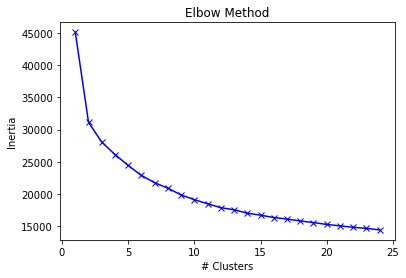

In [52]:
# Assessing optimum for number of clusters
elbow_inertia(25)

In [53]:
#add clusters to initial spotify dataset
clusters = kmeans.predict(X_prep_df)
df['clusters'] = clusters